Calculation of Unmixing Coefficients and G Parameter
====================================================
---
_Borys Olifirov, 07.2023_

## Theoretical intro

Based on _Zal and Gascoigne, 2004, doi: 10.1529/biophysj.103.022087_

__Intensity notation__

$$I_{XM(T)}$$

- X - excitation type
- M - emission type
- T - transfection type (A if acceptor only cells), does not present for co-transfected cells


### Sensitized-emission

$$F_c = I_{DA} - a (I_{AA} - c I_{DD}) - d (I_{DD} - b I_{AA})$$

$$F_c = I_{DA} - a I_{AA} - d I_{DD}$$
$$if$$
$$b \approx c \approx 0$$


### Crosstalc caliration

$$a = \frac{I_{DA(A)}}{I_{AA(A)}}$$
$$b = \frac{I_{DD(A)}}{I_{AA(A)}}$$
$$c = \frac{I_{AA(D)}} {I_{DD(D)}}$$
$$d = \frac{I_{DA(D)}} {I_{DD(D)}}$$

$$b \approx c \approx 0$$


### Determination of the G parameter

$$G = \frac{F_c}{I_{DD}^{post} - I_{DD}} = \frac{(I_{DA} - a I_{AA} - d I_{DD}) - (I_{DA}^{post} - a I_{AA}^{post} - d I_{DD}^{post})}{I_{DD}^{post} - I_{DD}}$$


### E-FRET

$$E_{app} = \frac{R}{R+G}, R = \frac{F_c}{I_{DD}}$$

$$E_{corr} = E_{app}(t) \frac{[A^0]_{tot}}{[A^t]_{tot}} = E_{app}(t) \times \frac{\overline{I_{AA}^0 - c I_{DD}^0}}{\overline{I_{AA}(t) - c I_{DD}(t)}}$$

## Script

In [4]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io
from skimage import transform
from skimage import registration

from scipy import ndimage
from scipy import signal
from scipy import stats
from scipy import ndimage as ndi

### Crosstalk

#### Class for calibration registration

In [2]:
class CrossReg():
    def __init__(self, data_path, data_name, exp_list, reg_type, trim_frame=-1, mask=True):
        self.img_name = data_name
        self.img_type = reg_type
        self.img_path = data_path
        self.img_raw = io.imread(self.img_path)[:trim_frame]

        self.D_exp = exp_list[0]
        self.A_exp = exp_list[1]

        self.DD_img = self.img_raw[:,:,:,0]  # CFP-435  DD
        self.DA_img = self.img_raw[:,:,:,1]  # YFP-435  DA
        self.AD_img = self.img_raw[:,:,:,2]  # CFP-505  AD
        self.AA_img = self.img_raw[:,:,:,3]  # YFP-505  AA

        self.DD_mean_img = np.mean(self.DD_img, axis=0)
        self.DA_mean_img = np.mean(self.DA_img, axis=0)
        self.AD_mean_img = np.mean(self.AD_img, axis=0)
        self.AA_mean_img = np.mean(self.AA_img, axis=0)

        if mask:
            self.mask = self.__cell_mask()

            self.DD_img = self.__mask_along_frames(self.DD_img, self.mask)
            self.DA_img = self.__mask_along_frames(self.DA_img, self.mask)
            self.AD_img = self.__mask_along_frames(self.AD_img, self.mask)
            self.AA_img = self.__mask_along_frames(self.AA_img, self.mask)


    @staticmethod
    def __mask_along_frames(series, mask):
        masked_series = []
        for frame in series:
            back_mean = np.mean(frame, where=mask)
            masked_frame = np.copy(frame)
            masked_frame[~mask] = back_mean / 4
            masked_series.append(masked_frame)
        return np.asarray(masked_series)


    def __cell_mask(self):
        if self.img_type == 'A':
            raw_mask = self.AA_mean_img > filters.threshold_otsu(self.AA_mean_img)
        elif self.img_type == 'D':
            raw_mask = self.DD_mean_img > filters.threshold_otsu(self.DD_mean_img)

        mask = morphology.opening(raw_mask, footprint=morphology.disk(10))
        mask = morphology.erosion(mask, footprint=morphology.disk(5))
        return mask


    def cross_calc(self):
        if self.img_type == 'A':
            self.a_arr = np.asarray([np.mean(self.DA_img[i] / self.AA_img[i]) for i in range(0, self.img_raw.shape[0])])
            self.b_arr = np.asarray([np.mean(self.AD_img[i] / self.AA_img[i]) for i in range(0, self.img_raw.shape[0])])

            self.a = np.mean(self.a_arr)
            self.a_sd = np.std(self.a_arr)

            self.b = np.mean(self.b_arr)
            self.b_sd = np.std(self.b_arr)

            a_df = pd.DataFrame({'ID':np.full(len(self.a_arr), self.img_name),
                                 'type':np.full(len(self.a_arr), self.img_type),
                                 'A_exp':np.full(len(self.a_arr), self.A_exp),
                                 'D_exp':np.full(len(self.a_arr), self.D_exp),
                                 'frame':range(len(self.a_arr)),
                                 'coef':np.full(len(self.a_arr), 'a'),
                                 'val':self.a_arr})
            b_df = pd.DataFrame({'ID':np.full(len(self.b_arr), self.img_name),
                                 'type':np.full(len(self.b_arr), self.img_type),
                                 'A_exp':np.full(len(self.b_arr), self.A_exp),
                                 'D_exp':np.full(len(self.b_arr), self.D_exp),
                                 'frame':range(len(self.b_arr)),
                                 'coef':np.full(len(self.b_arr), 'b'),
                                 'val':self.b_arr})
            self.cross_df = pd.concat([a_df, b_df], ignore_index=True)

            coef_dict = {'ID':[self.img_name, self.img_name],
                         'type':[self.img_type, self.img_type],
                         'A_exp':[self.A_exp, self.A_exp],
                         'D_exp':[self.D_exp, self.D_exp],
                         'coef':['a', 'b'],
                         'val':[self.a, self.b],
                         'sd':[self.a_sd, self.b_sd]}
            self.coef_df = pd.DataFrame(coef_dict)

        elif self.img_type == 'D':
            self.c_arr = np.asarray([np.mean(self.AA_img[i] / self.DD_img[i]) \
                                     for i in range(0, self.img_raw.shape[0])])
            self.d_arr = np.asarray([np.mean(self.DA_img[i] / self.DD_img[i]) \
                                     for i in range(0, self.img_raw.shape[0])])

            self.c = np.mean(self.c_arr)
            self.c_sd = np.std(self.c_arr)

            self.d = np.mean(self.d_arr)
            self.d_sd = np.std(self.d_arr)

            c_df = pd.DataFrame({'ID':np.full(len(self.c_arr), self.img_name),
                                 'type':np.full(len(self.c_arr), self.img_type),
                                 'A_exp':np.full(len(self.c_arr), self.A_exp),
                                 'D_exp':np.full(len(self.c_arr), self.D_exp),
                                 'frame':range(len(self.c_arr)),
                                 'coef':np.full(len(self.c_arr), 'c'),
                                 'val':self.c_arr})
            d_df = pd.DataFrame({'ID':np.full(len(self.d_arr), self.img_name),
                                 'type':np.full(len(self.d_arr), self.img_type),
                                 'A_exp':np.full(len(self.d_arr), self.A_exp),
                                 'D_exp':np.full(len(self.d_arr), self.D_exp),
                                 'frame':range(len(self.d_arr)),
                                 'coef':np.full(len(self.d_arr), 'd'),
                                 'val':self.d_arr})
            self.cross_df = pd.concat([c_df, d_df], ignore_index=True)

            coef_dict = {'ID':[self.img_name, self.img_name],
                         'type':[self.img_type, self.img_type],
                         'A_exp':[self.A_exp, self.A_exp],
                         'D_exp':[self.D_exp, self.D_exp],
                         'coef':['c', 'd'],
                         'val':[self.c, self.d],
                         'sd':[self.c_sd, self.d_sd]}
            self.coef_df = pd.DataFrame(coef_dict)


    def plot_hist(self):
        plt.figure(figsize=(8,8))

        ax0 = plt.subplot(211)
        ax0.hist(self.DD_mean_img.ravel(), bins=256,
                 alpha=.5,label='Ch 0 (CFP-435)', color='r')
        ax0.hist(self.DA_mean_img.ravel(), bins=256,
                 alpha=.5, label='Ch 1 (YFP-435)', color='g')
        ax0.hist(self.AD_mean_img.ravel(), bins=256,
                 alpha=.5, label='Ch 2 (CFP-505)', color='y')
        ax0.hist(self.AA_mean_img.ravel(), bins=256,
                 alpha=.5, label='Ch 3 (YFP-505)', color='b')
        ax0.legend()

        plt.title(f'File {self.img_name}, type {self.img_type}')
        plt.tight_layout()
        plt.show()


    def ff_profile(self):
        plt.figure(figsize=(8,4))

        ax0 = plt.subplot()
        ax0.plot(np.mean(self.DD_img, axis=(1,2)),
                 label='Ch 0 (CFP-435)', color='r')
        ax0.plot(np.mean(self.DA_img, axis=(1,2)),
                 label='Ch 1 (YFP-435)', color='g')
        ax0.plot(np.mean(self.AD_img, axis=(1,2)),
                 label='Ch 2 (CFP-505)', color='y')
        ax0.plot(np.mean(self.AA_img, axis=(1,2)),
                 label='Ch 3 (YFP-505)', color='b')
        ax0.legend()

        plt.title(f'File {self.img_name}, type {self.img_type}')
        plt.tight_layout()
        plt.show()        


    def ch_pic(self):
        int_min = np.min(self.img_raw)
        int_max = np.max(self.img_raw)


        plt.figure(figsize=(10,10))

        ax0 = plt.subplot(221)
        ax0.set_title('DD (Ch.0)')
        img0 = ax0.imshow(self.DD_mean_img, cmap='jet')
        img0.set_clim(vmin=int_min, vmax=int_max)
        div0 = make_axes_locatable(ax0)
        cax0 = div0.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img0, cax=cax0)
        ax0.axis('off')

        ax1 = plt.subplot(222)
        ax1.set_title('DA (Ch.1)')
        img1 = ax1.imshow(self.DA_mean_img, cmap='jet')
        img1.set_clim(vmin=int_min, vmax=int_max)
        div1 = make_axes_locatable(ax1)
        cax1 = div1.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img1, cax=cax1)
        ax1.axis('off')

        ax2 = plt.subplot(223)
        ax2.set_title('AD (Ch.2)')
        img2 = ax2.imshow(self.AD_mean_img, cmap='jet')
        img2.set_clim(vmin=int_min, vmax=int_max)
        div2 = make_axes_locatable(ax2)
        cax2 = div2.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img2, cax=cax2)
        ax2.axis('off')

        ax3 = plt.subplot(224)
        ax3.set_title('AA (Ch.3)')
        img3 = ax3.imshow(self.AA_mean_img, cmap='jet')
        img3.set_clim(vmin=int_min, vmax=int_max)
        div3 = make_axes_locatable(ax3)
        cax3 = div3.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img3, cax=cax3)
        ax3.axis('off')

        plt.suptitle(f'File {self.img_name}, type {self.img_type}')
        plt.tight_layout()
        plt.show()

        

#### Data uploading

In [3]:
img_path = 'data/crosstalk/'

donor_reg = {'01':[400, 200],  # [exp 435 ms, exp 505 ms]
             '02':[700, 300],
             '03':[500, 400]}
acceptor_reg = {'04':[500, 100],
                '05':[700, 200],
                '06':[500, 300]}

donor_reg_list = []
for reg_name in donor_reg.keys():
    name_path = img_path + f'{reg_name}.tif'
    donor_reg_list.append(CrossReg(data_path=name_path,
                                   data_name=reg_name,
                                   exp_list=donor_reg[reg_name],
                                   reg_type='D',
                                   trim_frame=-1))
acceptor_reg_list = []
for reg_name in acceptor_reg.keys():
    name_path = img_path + f'{reg_name}.tif'
    acceptor_reg_list.append(CrossReg(data_path=name_path,
                                      data_name=reg_name,
                                      exp_list=acceptor_reg[reg_name],
                                      reg_type='A',
                                      trim_frame=-1))

#### Analysis

Concatenation of all coeficients data frames

In [4]:
cross_coef_df = pd.DataFrame(columns=['ID',
                                      'type',
                                      'A_exp',
                                      'D_exp',
                                      'frame',
                                      'coef',
                                      'val'])

cross_val_df = pd.DataFrame(columns=['ID',
                                     'type',
                                     'A_exp',
                                     'D_exp',
                                     'coef',
                                     'val',
                                     'sd'])

for reg in acceptor_reg_list + donor_reg_list:
    reg.cross_calc()
    # reg.ch_pic()
    cross_coef_df = pd.concat([cross_coef_df, reg.cross_df], ignore_index=True)
    cross_val_df = pd.concat([cross_val_df, reg.coef_df], ignore_index=True)
    
    

In [27]:
cross_val_df.loc[cross_val_df.coef == 'a']

c=0.144+/-0.0318


,ID,type,A_exp,D_exp,coef,val,sd
0,04,A,100,500,a,0.175774,0.005592
2,05,A,200,700,a,0.657202,0.046830
4,06,A,300,500,a,0.112207,0.014132


In [26]:
cross_val_df.loc[cross_val_df.coef == 'b']

c=0.1292+/-0.0027


,ID,type,A_exp,D_exp,coef,val,sd
1,04,A,100,500,b,0.126509,0.005470
3,05,A,200,700,b,0.456507,0.045130
5,06,A,300,500,b,0.131851,0.010939


In [24]:
cross_val_df.loc[cross_val_df.coef == 'c']

c=0.2458+/-0.0298


,ID,type,A_exp,D_exp,coef,val,sd
6,01,D,200,400,c,0.216067,0.006042
8,02,D,300,700,c,0.275591,0.010731
10,03,D,400,500,c,0.082387,0.001150


In [20]:
cross_val_df.loc[cross_val_df.coef == 'd']

d=0.8506+/-0.0138


,ID,type,A_exp,D_exp,coef,val,sd
7,01,D,200,400,d,0.845942,0.002367
9,02,D,300,700,d,0.869356,0.003092
11,03,D,400,500,d,0.836573,0.000887


In [29]:
a_mean = np.mean(cross_val_df['val'][(cross_val_df['coef'] == 'a') & (cross_val_df['ID'] != '05')])
a_sd = np.std(cross_val_df['val'][(cross_val_df['coef'] == 'a') & (cross_val_df['ID'] != '05')])
print(f'a={round(a_mean, 4)}+/-{round(a_sd, 4)}')

b_mean = np.mean(cross_val_df['val'][(cross_val_df['coef'] == 'b') & (cross_val_df['ID'] != '05')])
b_sd = np.std(cross_val_df['val'][(cross_val_df['coef'] == 'b') & (cross_val_df['ID'] != '05')])
print(f'b={round(b_mean, 4)}+/-{round(b_sd, 4)}')

c_mean = np.mean(cross_val_df['val'][(cross_val_df['coef'] == 'c') & (cross_val_df['ID'] != '03')])
c_sd = np.std(cross_val_df['val'][(cross_val_df['coef'] == 'c') & (cross_val_df['ID'] != '03')])
print(f'c={round(c_mean, 4)}+/-{round(c_sd, 4)}')

d_mean = np.mean(cross_val_df['val'][cross_val_df['coef'] == 'd'])
d_sd = np.std(cross_val_df['val'][cross_val_df['coef'] == 'd'])
print(f'd={round(d_mean, 4)}+/-{round(d_sd, 4)}')

a=0.144+/-0.0318
b=0.1292+/-0.0027
c=0.2458+/-0.0298
d=0.8506+/-0.0138


__a__=0.144+/-0.0318

__b__=0.1292+/-0.0027

__c__=0.2458+/-0.0298

__d__=0.8506+/-0.0138


Vis.

In [5]:
fig = px.box(cross_coef_df, x='coef', y='val', color='ID', points='all')

fig.show()

### G parameter

#### Func.

In [10]:
class GReg():
    def __init__(self, img_name, raw_path, bleach_path, bleach_frame, bleach_exp, A_exp, D_exp, coef_list, trim_frame=-1, mask=True):
        self.img_name = img_name
        self.img_raw = io.imread(raw_path)[:trim_frame]
        self.img_bleach = io.imread(bleach_path)[:trim_frame]

        self.bleach_frame = bleach_frame
        self.bleach_exp = bleach_exp
        self.A_exp = A_exp
        self.D_exp = D_exp

        self.a = coef_list[0]
        self.b = coef_list[1]
        self.c = coef_list[2]
        self.d = coef_list[3]


        self.DD_img = self.img_raw[:,:,:,0]  # CFP-435  DD
        self.DA_img = self.img_raw[:,:,:,1]  # YFP-435  DA
        self.AD_img = self.img_raw[:,:,:,2]  # CFP-505  AD
        self.AA_img = self.img_raw[:,:,:,3]  # YFP-505  AA

        self.DD_img_post = self.img_bleach[:,:,:,0]
        self.DA_img_post = self.img_bleach[:,:,:,1]
        self.AD_img_post = self.img_bleach[:,:,:,2]
        self.AA_img_post = self.img_bleach[:,:,:,3]


        self.DD_mean_img = np.mean(self.DD_img, axis=0)
        self.DA_mean_img = np.mean(self.DA_img, axis=0)
        self.AD_mean_img = np.mean(self.AD_img, axis=0)
        self.AA_mean_img = np.mean(self.AA_img, axis=0)

        if mask:
            self.mask = self.__cell_mask()

            self.DD_img = self.__mask_along_frames(self.DD_img, self.mask)
            self.DA_img = self.__mask_along_frames(self.DA_img, self.mask)
            self.AD_img = self.__mask_along_frames(self.AD_img, self.mask)
            self.AA_img = self.__mask_along_frames(self.AA_img, self.mask)


    @staticmethod
    def __mask_along_frames(series, mask):
        masked_series = []
        for frame in series:
            back_mean = np.mean(frame, where=mask)
            masked_frame = np.copy(frame)
            masked_frame[~mask] = back_mean / 4
            masked_series.append(masked_frame)
        return np.asarray(masked_series)


    def __cell_mask(self):
        raw_mask = self.AA_mean_img > filters.threshold_otsu(self.AA_mean_img)

        mask = morphology.opening(raw_mask, footprint=morphology.disk(10))
        mask = morphology.erosion(mask, footprint=morphology.disk(5))
        return mask


    def Fc_calc(self):
        pass


    def ch_pic(self):
        int_min = np.min(self.img_raw)
        int_max = np.max(self.img_raw)


        plt.figure(figsize=(10,10))

        ax0 = plt.subplot(221)
        ax0.set_title('DD (Ch.0)')
        img0 = ax0.imshow(self.DD_mean_img, cmap='jet')
        img0.set_clim(vmin=int_min, vmax=int_max)
        div0 = make_axes_locatable(ax0)
        cax0 = div0.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img0, cax=cax0)
        ax0.axis('off')

        ax1 = plt.subplot(222)
        ax1.set_title('DA (Ch.1)')
        img1 = ax1.imshow(self.DA_mean_img, cmap='jet')
        img1.set_clim(vmin=int_min, vmax=int_max)
        div1 = make_axes_locatable(ax1)
        cax1 = div1.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img1, cax=cax1)
        ax1.axis('off')

        ax2 = plt.subplot(223)
        ax2.set_title('AD (Ch.2)')
        img2 = ax2.imshow(self.AD_mean_img, cmap='jet')
        img2.set_clim(vmin=int_min, vmax=int_max)
        div2 = make_axes_locatable(ax2)
        cax2 = div2.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img2, cax=cax2)
        ax2.axis('off')

        ax3 = plt.subplot(224)
        ax3.set_title('AA (Ch.3)')
        img3 = ax3.imshow(self.AA_mean_img, cmap='jet')
        img3.set_clim(vmin=int_min, vmax=int_max)
        div3 = make_axes_locatable(ax3)
        cax3 = div3.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img3, cax=cax3)
        ax3.axis('off')

        plt.suptitle(f'File {self.img_name}')
        plt.tight_layout()
        plt.show()

#### Parameters

In [6]:
a = 0.144
b = 0.1292
c = 0.2458
d = 0.8506

abcd = [a, b, c, d]

#### Uploading

In [12]:
tandem_folder = 'data/tandem/'

tandem_reg = {'FOV1':['01', '02', 100, 800, 400, 100],  # [raw reg, post reg, bleach frames, bleach exp, 435 exp, 505 exp]
              'FOV2':['03', '04', 100, 800, 400, 200]}

tandem_reg_list = []
for reg_name in tandem_reg.keys():
    reg_params = tandem_reg[reg_name]
    raw_path = tandem_folder + f'{reg_params[0]}.tif'
    bleach_path = tandem_folder + f'{reg_params[1]}.tif'
    tandem_reg_list.append(GReg(img_name=reg_name,
                                raw_path=raw_path,
                                bleach_path=bleach_path,
                                bleach_frame=reg_params[2],
                                bleach_exp=reg_params[3],
                                A_exp=reg_params[4],
                                D_exp=reg_params[5],
                                coef_list=abcd))

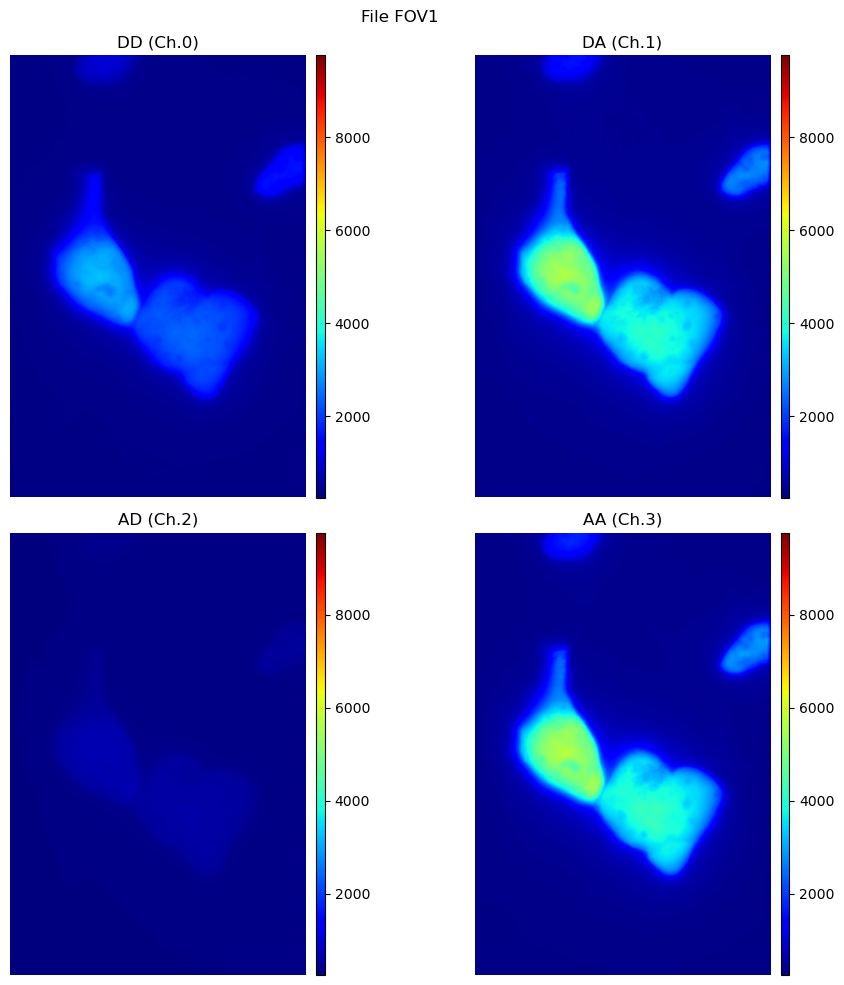

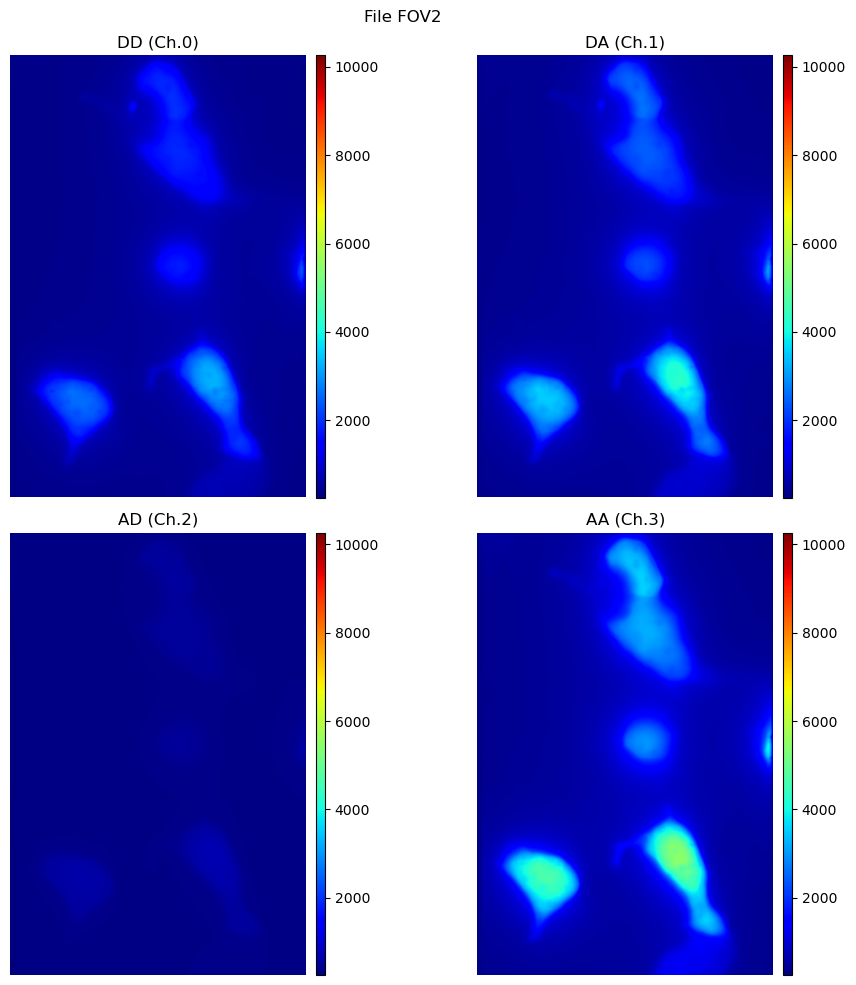

In [13]:
for reg in tandem_reg_list:
    reg.ch_pic()